## Avaliando [Crash Course](https://mxnet.apache.org/versions/master/api/python/docs/tutorials/getting-started/crash-course/6-train-nn.html)


In [1]:
import time
import os
import sys
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt 
import numpy as np


module_path = os.path.abspath(os.path.join('../../../scripts/CrashCourse'))
if module_path not in sys.path:
    sys.path.append(module_path)

from prepare_dataset import process_dataset

mx.np.random.seed(42)

In [2]:

if not os.path.isdir('../../../data/crashCourse/c6/plants') and not os.path.isdir('../../../data/crashCourse/c6/datasets'):

    url='https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'

    os.makedirs('../../../data/crashCourse/c6/',exist_ok=True)

    zip_file_path=mx.gluon.utils.download(url,path='../../../data/crashCourse/c6/')

    with zipfile.ZipFile(zip_file_path,'r') as zf:
        zf.extractall(path='../../../data/crashCourse/c6/plants')

    os.remove(zip_file_path)    

else:
    print('Nada a fazer, pois arquivos já estão lá')

Nada a fazer, pois arquivos já estão lá


### Data inspection

In [3]:
if not os.path.isdir('../../../data/crashCourse/c6/datasets'):
    process_dataset('../../../data/crashCourse/c6/plants',path='../../../data/crashCourse/c6')
else:
    print('Nada a fazer, pois arquivos já estão lá')

Nada a fazer, pois arquivos já estão lá


In [4]:
train_dataset=gluon.data.vision.ImageFolderDataset('../../../data/crashCourse/c6/datasets/train')
val_dataset=gluon.data.vision.ImageFolderDataset('../../../data/crashCourse/c6/datasets/validation')
test_dataset=gluon.data.vision.ImageFolderDataset('../../../data/crashCourse/c6/datasets/test')

[20:06:48] /home/mertins/Desenvolvimento/C/Terceiros/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for CPU


[ INFO:0] global /builddir/build/BUILD/opencv-4.5.3/modules/core/src/parallel/registry_parallel.impl.hpp (96) ParallelBackendRegistry core(parallel): Enabled backends(2, sorted by priority): TBB(1000); OPENMP(990)
[ INFO:0] global /builddir/build/BUILD/opencv-4.5.3/modules/core/include/opencv2/core/parallel/backend/parallel_for.tbb.hpp (54) ParallelForBackend Initializing TBB parallel backend: TBB_INTERFACE_VERSION=11103
[ INFO:0] global /builddir/build/BUILD/opencv-4.5.3/modules/core/src/parallel/parallel.cpp (77) createParallelForAPI core(parallel): using backend: TBB (priority=1000)
Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


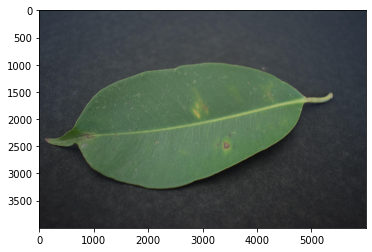

In [5]:
sample_idx=888
sample=train_dataset[sample_idx]
data=sample[0]
label=sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

### Data Augmentation
Using transforms

In [6]:
from mxnet.gluon.data.vision import transforms

jitter_param=0.05

mean=[0.485,0.456,0.406]
std=[0.229,0.224,0.255]

training_transformer=transforms.Compose([
    transforms.Resize(size=224,keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean,std)
])

validation_transformer=transforms.Compose([
    transforms.Resize(size=224,keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean,std)
])


##### Data loaders

In [7]:
batch_size=4

train_loader=gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                            batch_size=batch_size,
                            shuffle=True)

validation_loader=gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                            batch_size=batch_size,
                            shuffle=True)

test_loader=gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                            batch_size=batch_size,
                            shuffle=True)                     
                            

In [8]:
def show_batch(batch,columns=4,fig_size=(9,5),pad=1):
    labels=batch[1].asnumpy()
    batch=batch[0]/2+0.5
    batch=np.clip(batch.asnumpy(),0,1)
    size=batch.shape[0]
    rows=int(size/columns)
    fig, axes=plt.subplots(rows,columns,figsize=fig_size)
    for ax,img,label in zip(axes.flatten(),batch,labels):
        ax.imshow(np.transpose(img,(1,2,0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad,w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a=batch
    break

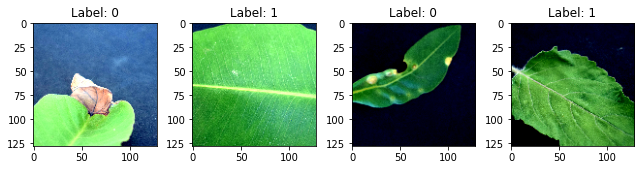

In [10]:
show_batch(a)

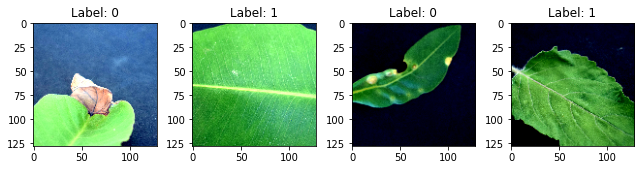

In [11]:
show_batch(a)

## Create neural network

The convolutional block has a convolution layer, a max pool layer and a batch normalization layer

In [12]:
def conv_block(filters,kernel_size=2,stride=2,batch_norm=True):
    conv_block=nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters,kernel_size=kernel_size,activation='relu'),
                                nn.MaxPool2D(pool_size=4,strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

The dense block consists of a dense layer and a dropout layer

In [13]:
def dense_block(neurons,activation='relu',dropout=0.2):
    dense_block=nn.HybridSequential()
    dense_block.add(nn.Dense(neurons,activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

Create neural network blueprint using blocks

In [14]:
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

Create the model based on the blueprint provided and initialize the parameters

In [15]:
device=npx.gpu() if npx.num_gpus() > 0 else npx.cpu()

initializer=mx.initializer.Xavier()

model=LeafNetwork()

model.initialize(initializer,device=device)
model.summary(mx.np.random.uniform(size=(4,3,128,128),device=device))
model.hybridize()

[20:06:54] /home/mertins/Desenvolvimento/C/Terceiros/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

### Choose Optimizer and Loss funcion

In [16]:
optimizer='sgd'

optimizer_params={'learning_rate':0.001}

trainer=gluon.Trainer(model.collect_params(), optimizer,optimizer_params)

loss_fn=gluon.loss.SoftmaxCrossEntropyLoss()

[20:07:00] /home/mertins/Desenvolvimento/C/Terceiros/mxnet/src/operator/cudnn_ops.cc:353: Auto-tuning cuDNN op, set MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable


Function to return the accuracy for the validation and test set

In [17]:
def test(val_data):
    acc=gluon.metric.Accuracy()
    for batch in val_data:
        data=batch[0]
        labels=batch[1]
        outputs=model(data.to_device(device))
        acc.update([labels],[outputs])

    _,accuracy=acc.get()
    return accuracy

### Training Loop

In [18]:
epochs=2
accuracy=gluon.metric.Accuracy()
log_interval=5

for epoch in range(epochs):
    tic=time.time()
    btic=time.time()
    accuracy.reset()

    for idx,batch in enumerate(train_loader):
        data=batch[0]
        label=batch[1]
        with mx.autograd.record():
            outputs=model(data.to_device(device))
            loss=loss_fn(outputs,label.to_device(device))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label],[outputs])
        if log_interval and (idx+1)%log_interval==0:
            _,acc=accuracy.get()
            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")



[20:07:02] /home/mertins/Desenvolvimento/C/Terceiros/mxnet/src/operator/cudnn_ops.cc:353: Auto-tuning cuDNN op, set MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable


Epoch[1] Batch[5] Speed: 0.7074651689530481 samples/sec                   batch loss = 0.44753286242485046 | accuracy = 0.8
Epoch[1] Batch[10] Speed: 1.3038789140539038 samples/sec                   batch loss = 0.724275529384613 | accuracy = 0.675
Epoch[1] Batch[15] Speed: 1.3359310010116698 samples/sec                   batch loss = 0.4305137097835541 | accuracy = 0.7333333333333333
Epoch[1] Batch[20] Speed: 1.3353675464893267 samples/sec                   batch loss = 2.284557580947876 | accuracy = 0.675
Epoch[1] Batch[25] Speed: 1.327124083119914 samples/sec                   batch loss = 1.840815544128418 | accuracy = 0.66
Epoch[1] Batch[30] Speed: 1.3188630520206441 samples/sec                   batch loss = 0.19064268469810486 | accuracy = 0.6666666666666666
Epoch[1] Batch[35] Speed: 1.3002299882479385 samples/sec                   batch loss = 0.5818670392036438 | accuracy = 0.6571428571428571
Epoch[1] Batch[40] Speed: 1.2895884807571925 samples/sec                   batch loss

In [19]:
test(test_loader)

0.7611111111111111

In [ ]:
model.save_parameters('../../../data/crashCourse/models/leaf_models_cc6.params')